In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 4 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_4____2020_08_26_13_09_01_108620_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
# https://github.com/tanzhenyu/image_augmentation

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation, BatchNormalization, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.initializers import RandomNormal, HeNormal
from tensorflow.keras import Input, Model

from tensorflow.keras import backend as K

from functools import partial

CHANNEL_AXIS = 1 if K.image_data_format() == 'channels_first' else -1

_batch_norm = partial(BatchNormalization, axis=CHANNEL_AXIS,
                      momentum=0.1, epsilon=1e-5, gamma_initializer=RandomNormal(0., 1.))
_relu = partial(Activation, 'relu')


def _residual_block(input, num_filters=16, k=1, stride=1,
                    dropout=0.0, name='res_block'):
    """Pre-activated residual block."""
    num_filters = num_filters * k
    init = branch = input

    init = _batch_norm(name=name + '/bn1')(init)
    init = _relu(name=name + '/relu1')(init)
    if init.shape[CHANNEL_AXIS] != num_filters or name.endswith("block1"):
        branch = Conv2D(num_filters, (1, 1), strides=stride, padding='same',
                        use_bias=False, kernel_initializer=HeNormal(),
                        name=name + '/conv_identity_1x1')(init)

    x = Conv2D(num_filters, (3, 3), strides=stride, padding='same',
               use_bias=False, kernel_initializer=HeNormal(),
               name=name + '/conv1_3x3')(init)

    if dropout > 0.0:
        x = Dropout(dropout, name=name + '/dropout')(x)

    x = _batch_norm(name=name + '/bn2')(x)
    x = _relu(name=name + '/relu2')(x)
    x = Conv2D(num_filters, (3, 3), strides=1, padding='same',
               use_bias=False, kernel_initializer=HeNormal(),
               name=name + '/conv2_3x3')(x)

    x = Add(name=name + '/add')([branch, x])

    return x


def WideResNet(input_shape, depth=28, k=10, dropout=0.0,
               num_classes=10, name=None):
    """This is an implementation of WideResNet architecture
    as described in "Wide Residual Networks" by Zagoruyko, Komodakis
    (https://arxiv.org/abs/1605.07146).
    """
    if name is None:
        name = 'WideResNet' + '-' + str(depth) + '-' + str(k)

    assert (depth - 4) % 6 == 0, "depth must be 6n + 4"
    n = (depth - 4) // 6

    filters = [(16 * (2 ** i)) for i in range(3)]

    inp = Input(input_shape, name='input')

    # conv1
    x = Conv2D(16, (3, 3), padding='same', use_bias=False,
               kernel_initializer=HeNormal(),
               name='conv1/conv_3x3')(inp)

    # conv2: n blocks
    for i in range(n):
        x = _residual_block(x, num_filters=filters[0], k=k,
                            stride=1, dropout=dropout,
                            name='conv2' + '/block' + str(i + 1))

    # conv3: n blocks
    for i in range(n):
        stride = 2 if i == 0 else 1
        x = _residual_block(x, num_filters=filters[1], k=k,
                            stride=stride, dropout=dropout,
                            name='conv3' + '/block' + str(i + 1))

    # conv4: n blocks
    for i in range(n):
        stride = 2 if i == 0 else 1
        x = _residual_block(x, num_filters=filters[2], k=k,
                            stride=stride, dropout=dropout,
                            name='conv4' + '/block' + str(i + 1))

    x = _batch_norm(name='bn')(x)
    x = _relu(name='relu')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(num_classes, activation='softmax',
              kernel_initializer=HeNormal(), name='preds')(x)

    net = Model(inp, x, name=name)
    return net

In [9]:
model = WideResNet(dims, depth=28, k=2, dropout=0.5, num_classes=num_classes)

In [10]:
model.summary()

Model: "WideResNet-28-2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1/conv_3x3 (Conv2D)         (None, 32, 32, 16)   432         input[0][0]                      
__________________________________________________________________________________________________
conv2/block1/bn1 (BatchNormaliz (None, 32, 32, 16)   64          conv1/conv_3x3[0][0]             
__________________________________________________________________________________________________
conv2/block1/relu1 (Activation) (None, 32, 32, 16)   0           conv2/block1/bn1[0][0]           
____________________________________________________________________________________

### Augmentation

In [13]:
import tensorflow_addons as tfa
def augment(image, label):
        # image = tf.squeeze(image)  # Add 6 pixels of padding
        image = tf.image.resize_with_crop_or_pad(
            image, dims[0] + 6, dims[1] + 6
        )  # crop 6 pixels
        image = tf.image.random_crop(image, size=dims)
        image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
        image = tf.image.random_contrast(image, lower=0.6, upper=1.4)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_hue(image, 0.05, seed=None)
        # image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
        image = tfa.image.rotate(
            image,
            tf.squeeze(tf.random.uniform(shape=(1, 1), minval=-0.2, maxval=0.2)),
            interpolation="BILINEAR",
        )
        image = tfa.image.random_cutout(
            tf.expand_dims(image, 0), (8, 8), constant_values=0.5
        )[0]
        image = tf.clip_by_value(image, 0, 1)
        return image, label

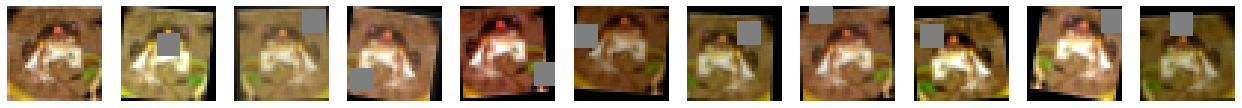

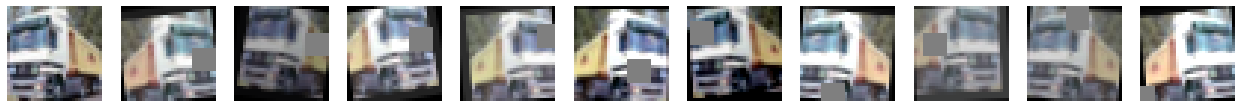

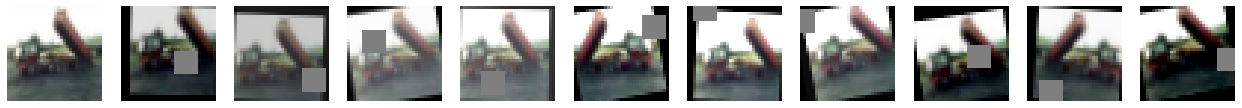

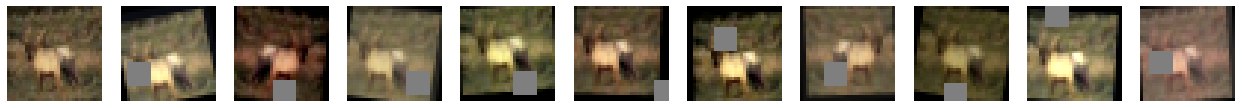

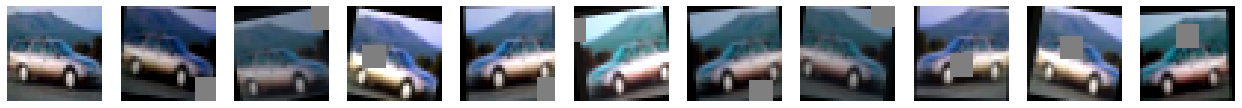

In [14]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(np.squeeze(X_train[i]), cmap = plt.cm.Greys)
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        aug_img = np.squeeze(augment(X_train[i], Y_train[i])[0])
        ax.matshow(aug_img, cmap = plt.cm.Greys, vmin=0, vmax=1)
        ax.axis('off')

### train

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

In [16]:
import tensorflow_addons as tfa

In [17]:
opt = tf.keras.optimizers.Adam(1e-4)
opt = tfa.optimizers.MovingAverage(opt)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(opt, loss = loss, metrics=['accuracy'])

In [18]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [19]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [20]:
from livelossplot import PlotLossesKerasTF
# plot losses callback
plotlosses = PlotLossesKerasTF()

In [21]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .repeat()
    .shuffle(len(X_labeled))
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

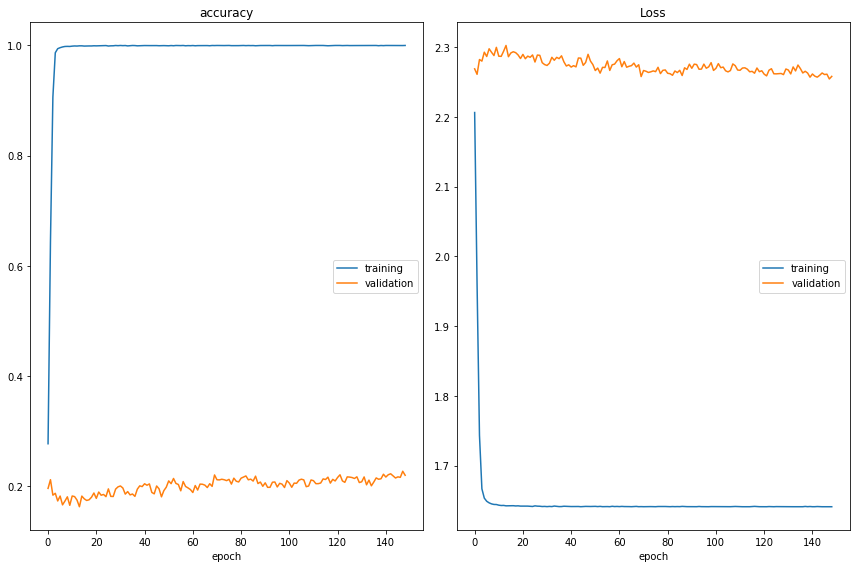

accuracy
	training         	 (min:    0.277, max:    1.000, cur:    1.000)
	validation       	 (min:    0.163, max:    0.227, cur:    0.220)
Loss
	training         	 (min:    1.641, max:    2.206, cur:    1.641)
	validation       	 (min:    2.254, max:    2.302, cur:    2.258)
312/312 [==============================] - 18s 58ms/step - loss: 1.6412 - accuracy: 1.0000 - val_loss: 2.2579 - val_accuracy: 0.2198
Epoch 150/500
195/312 [=================>............] - ETA: 6s - loss: 1.6412 - accuracy: 1.0000

KeyboardInterrupt: 

In [22]:
steps_per_epoch = int(len(X_train)/ batch_size)

history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping, plotlosses],
    steps_per_epoch = steps_per_epoch,
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

In [ ]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [ ]:
predictions = model.predict(X_valid)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [ ]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

### save results

In [ ]:
# save score, valid embedding, weights, results

In [ ]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [ ]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [ ]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [ ]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [ ]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

In [ ]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [ ]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

In [ ]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [ ]:
z = encoder.predict(X_train)

In [ ]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [ ]:
import pickle

In [ ]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
print('test')